In [1]:
from molecule_validation import is_odorant, score_molecule
from reward_sheduling_conditional import SchedulingConditional,RewardSchedulingConditional

c:\Users\paulj\Desktop\Master\venv\lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\paulj\Desktop\Master\venv\lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\paulj\Desktop\Master\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthe

In [2]:
import socket
from typing import Dict, List, Tuple

import torch
from rdkit import Chem
from rdkit.Chem.rdchem import Mol as RDMol
from torch import Tensor
from numpy.linalg import norm

from gflownet import GFNTask, LogScalar, ObjectProperties
from gflownet.config import Config, init_empty
from gflownet.envs.mol_building_env import MolBuildingEnvContext
from gflownet.online_trainer import StandardOnlineTrainer
import json
import os
import pathlib
import numpy as np
from rdkit.Chem.Draw import MolsToGridImage, MolToImage
 from submodels.openpom.functions import fragance_propabilities_from_smiles

TARGET_SMILES = "COC1=C(C=CC(=C1)C=O)O"
TARGET_VEC = fragance_propabilities_from_smiles(TARGET_SMILES)[0]
from gflownet.utils.misc import create_logger
import gc
from gflownet.utils.transforms import to_logreward


import time


class MakeRingsTask(GFNTask):

    def __init__(self,cfg: Config):
            self.cfg = cfg
            self.scheduling_conditional = RewardSchedulingConditional(cfg)
            self.min_reward = np.exp(cfg.algo.illegal_action_logreward)

    def sample_conditional_information(self, n: int, train_it: int) -> Dict[str, Tensor]:
        # Encoding lets the model know that codniotional information is applied
        return self.scheduling_conditional.sample(n, train_it)

    def cond_info_to_logreward(self, cond_info: Dict[str, Tensor], obj_props: ObjectProperties) -> LogScalar:
        #cond_info["reward_scheduling"]
        #scalar_logreward = torch.as_tensor(obj_props).squeeze().clamp(min=1e-30).log()
        #return LogScalar(scalar_logreward.flatten())
        scalarized_rewards = self.scheduling_conditional.transform(cond_info, obj_props)
        scalarized_logrewards = to_logreward(scalarized_rewards)
        clamped_logrewards = scalarized_logrewards.clamp(min=self.cfg.algo.illegal_action_logreward)
        return LogScalar(clamped_logrewards)

    def compute_obj_properties(self, mols: List[RDMol]) -> Tuple[ObjectProperties, Tensor]:
        #is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 for m in mols ]).bool()
        is_valid = torch.tensor([m.GetNumAtoms() > 1 for m in mols ]).bool()
        if not is_valid.any():
            return ObjectProperties(torch.zeros((0,3))), is_valid
        valid_mols = [mol for mol, valid in zip(mols, is_valid) if valid]
        
        params = []
        for m in valid_mols:
            p0 =score_molecule(m) 
            p1 =self.is_odorant(m)
            p2 = self.has_target_scent(m)
            assert self.mcf_mean(p0) !=  None, f"Invalid molecule score mean! Value: {self.mcf_mean(p0)} {p0}"
            assert self.mcf_product(p0) !=  None, f"Invalid molecule score product! Value: {self.mcf_mean(p0)} {p0}"
            assert p1 !=  None, f"Invalid molecule is odorant score! Value: {p1}"
            assert p2 !=  None, f"Invalid molecule target scent similarity! Value: {p2}"
            params.append((p0,p1,p2))
        #params = [(score_molecule(m),self.is_odorant(m),self.has_target_scent(m)) for m in valid_mols]
        #rs = torch.tensor([m.GetRingInfo().NumRings() + get_flour(m) for m in mols]).float()
        #rs = torch.tensor([[valid_reward(m),odor_reward(m),reward_func(m)] for m in valid_mols]).float()
        rs = torch.tensor([[
            max(self.mcf_mean(p[0]), self.min_reward), 
            max(np.mean([self.mcf_product(p[0]), p[1]]), self.min_reward),
            max(np.mean([self.mcf_product(p[0]),p[1],p[2]]), self.min_reward),
            max(self.mcf_product(p[0])*p[1]*p[2], self.min_reward)
            ] for p in params]).float()
        #rs = torch.tensor([reward_func(m) for m in valid_mols]).float()
        return ObjectProperties(rs), is_valid
    
    def cosine_similarity(self,vec1,vec2):
        return np.dot(vec1,vec2)/(norm(vec1)*norm(vec2))
    
    # Objective functions
    def mcf_mean(self, scores):
        return np.mean(scores)


    def mcf_product(self, scores):
        result =  int(all(scores))
        return result

    def is_odorant(self,m):
        #TODO: Optimize by passing batch of mols instead of single mols. 
        result =  int(all(is_odorant(m).astype(int)))
        if result is not None and not np.isnan(result):
            return result
        print(f"Warning: is_odorant failed on mol: {Chem.MolToSmiles(m)}")
        return 0

    def has_target_scent(self, m):
        m_smiles = Chem.MolToSmiles(m)
        m_vec = fragance_propabilities_from_smiles(m_smiles)[0]
        result =  self.cosine_similarity(TARGET_VEC,m_vec)
        if result is not None and not np.isnan(result):
            return result
        print(f"Warning: has_target_scent failed on mol: {m_smiles}")
        return 0

class MakeRingsTrainer(StandardOnlineTrainer):
    def set_default_hps(self, cfg: Config):
        
        cfg.hostname = socket.gethostname()
        cfg.num_workers = 8
        cfg.algo.num_from_policy = 64
        cfg.model.num_emb = 128
        cfg.model.num_layers = 4

        cfg.algo.method = "TB"
        cfg.algo.max_nodes = 20
        cfg.algo.sampling_tau = 0.9
        cfg.algo.illegal_action_logreward = -75
        cfg.algo.train_random_action_prob = 0.0
        cfg.algo.valid_random_action_prob = 0.0
        cfg.algo.tb.do_parameterize_p_b = True

        cfg.replay.use = False

    def setup_task(self):
        self.task = MakeRingsTask(self.cfg)

    def setup_env_context(self):
        self.ctx = MolBuildingEnvContext(
            ["C","N","O","F"],
            charges=[0],  # disable charge
            chiral_types=[Chem.rdchem.ChiralType.CHI_UNSPECIFIED],  # disable chirality
            num_rw_feat=0,
            expl_H_range=[0],
            max_nodes=self.cfg.algo.max_nodes,
            num_cond_dim=1,
        )

    


def save_run(trial):
    state = {
        "models_state_dict": [trial.model.state_dict()],
        "cfg": trial.cfg,
        "env_ctx": trial.model.env_ctx,
        #"model": trial.model,
    }
    if trial.sampling_model is not trial.model:
        state["sampling_model_state_dict"] = [trial.sampling_model.state_dict()]
    fn = pathlib.Path(trial.cfg.log_dir) / "model_final_save.pt"
    with open(fn, "wb") as fd:
        torch.save(
            state,
            fd,
        )




  



No normalization for SPS. Feature removed!
No normalization for AvgIpc. Feature removed!
wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead


wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [3]:
def sample(n, train_it):

    #(train_it >= self.thresholds).int().unsqueeze(0).expand(n, -1)
    #preferences = (train_it >= self.thresholds).int().unsqueeze(0).expand(n, -1)
    #preferences = torch.as_tensor(preferences).float()
    #return {"preferences": preferences, "encoding": self.encode(preferences)}


    cum_preferences = (train_it >= torch.tensor([0,10,20,30])).int()

    shift = torch.cat([cum_preferences[1:], torch.tensor([0], dtype=cum_preferences.dtype)])

    preferences = cum_preferences-shift
    preferences = preferences.unsqueeze(0).expand(n, -1)
    preferences = torch.as_tensor(preferences).float()



    return preferences

sample(10, 11)

tensor([[0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.]])

In [4]:
"""Example of how this model can be run."""
config = init_empty(Config())
config.print_every = 1
config.log_dir = "./logs/debug_run_mr15"

# For CPU
config.device = torch.device('cpu')
config.num_workers = 0

# For reproduction
config.seed = 1 

config.num_training_steps = 200 #10_000

config.algo.tb.do_parameterize_p_b = False # Dont know how to load the model with this parameter = True
config.num_validation_gen_steps = 1



trial = MakeRingsTrainer(config)
trial.run()
save_run(trial)




Hyperparameters:

desc: noDesc
log_dir: ./logs/debug_run_mr15
device: cpu
seed: 1
validate_every: 1000
checkpoint_every: null
store_all_checkpoints: false
print_every: 1
start_at_step: 0
num_final_gen_steps: null
num_validation_gen_steps: 1
num_training_steps: 200
num_workers: 0
hostname: LAPTOP-JIE0TNQT
pickle_mp_messages: false
git_hash: unknown
overwrite_existing_exp: false
algo:
  method: TB
  num_from_policy: 64
  num_from_dataset: 0
  valid_num_from_policy: 64
  valid_num_from_dataset: 0
  max_len: 128
  max_nodes: 20
  max_edges: 128
  illegal_action_logreward: -75.0
  train_random_action_prob: 0.0
  train_det_after: null
  valid_random_action_prob: 0.0
  sampling_tau: 0.9
  tb:
    bootstrap_own_reward: false
    epsilon: null
    reward_loss_multiplier: 1.0
    variant: TB
    do_correct_idempotent: false
    do_parameterize_p_b: false
    do_predict_n: false
    do_sample_p_b: false
    do_length_normalize: false
    subtb_max_len: 128
    Z_learning_rate: 0.0001
    Z_lr_d

structural similarity
different chemical parameter

Change reward in later epochs to consider descriptor. 

1 step invalid 

In [5]:
from rdkit.Chem.Draw import MolsToGridImage, MolToImage

In [6]:
trajs = trial.algo.create_training_data_from_own_samples(trial.model, 25)
objs = [trial.ctx.graph_to_obj(i['result']) for i in trajs]

In [7]:
obj_props, is_valid = trial.task.compute_obj_properties(objs)

In [8]:
is_valid

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True])

In [9]:
cond_info = trial.task.sample_conditional_information(len(obj_props), 1)

In [10]:
log_rewards = trial.task.cond_info_to_logreward(cond_info, obj_props)
log_rewards

tensor([-0.8473, -0.8473, -0.8473, -0.8473, -0.8473, -0.8473, -0.8473, -0.8473,
        -0.8473, -0.8473, -0.8473, -0.8473, -0.8473, -0.8473, -0.8473, -0.8473,
        -0.8473, -0.8473, -0.8473, -0.8473, -0.8473, -0.8473, -0.8473, -0.8473,
        -0.8473])

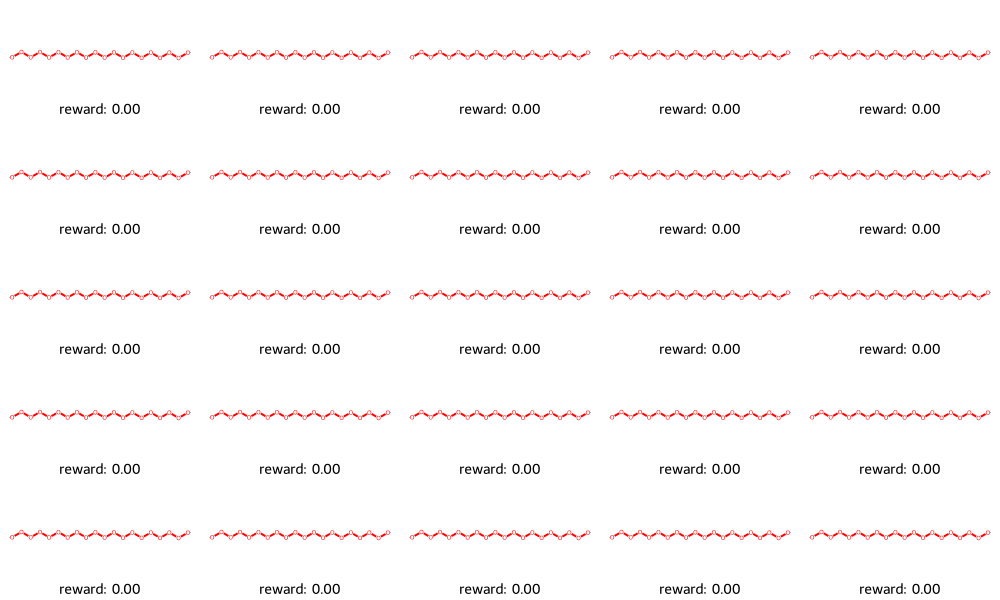

In [14]:
# Generate molecules
trajs = trial.algo.create_training_data_from_own_samples(trial.model, 25)
objs = [trial.ctx.graph_to_obj(i['result']) for i in trajs]
obj_props, is_valid = trial.task.compute_obj_properties(objs)
cond_info = trial.task.sample_conditional_information(len(obj_props), 200)
log_rewards = trial.task.cond_info_to_logreward(cond_info, obj_props)


MolsToGridImage(objs[:25], molsPerRow=5, subImgSize=(200, 120), legends=[f'reward: {r.exp().item():.2f}' for r in log_rewards[:25]])

In [ ]:
2

1

Model training might be wrong



In [7]:
print([Chem.MolToSmiles(obj) for obj in objs])

['[O]OO[C]1[CH]O1', '[C]NC(O)C#N', 'COC1[N][CH]O1', 'N=C1C2C3=CC132', 'CN=C(F)O[NH]', 'OONOOO', '[CH]OC(F)OF', 'OON1C2ON21', '[N]n1on1ON', 'CC1CCN1[N]', 'CC=NOO', '[C]N1NC(=[CH])O1', 'N1OC23NN2N13', 'CC(O)(F)CN', 'CN(F)OC#N', 'FNN(F)OF', '[C]OC([O])N=O', 'NN=NC1[C]O1', '[N]C1(O)CN1O', 'n1on2o[nH]c12', '[N][C]1[N]NN1O', 'C1NNN2CN12', 'NC(O)(F)OO', '[NH][C](OO)OF', 'CO[C]=COC']


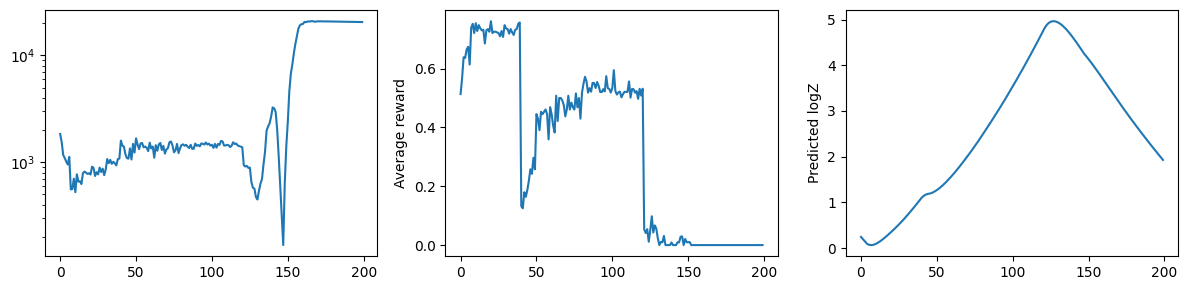

In [15]:
from gflownet.config import init_empty, Config
cfg = init_empty(Config())
from tensorboard.backend.event_processing import event_accumulator

cfg.log_dir = config.log_dir
ea = event_accumulator.EventAccumulator(cfg.log_dir)
ea.Reload()

import matplotlib.pyplot as pp
f, ax = pp.subplots(1, 3, figsize=(4*3,3))
ax[0].plot([i.value for i in ea.Scalars('train_loss')])
ax[0].set_yscale('log')
ax[1].set_ylabel('TB loss')
ax[1].plot([i.value for i in ea.Scalars('train_sampled_reward_avg')])
ax[1].set_ylabel('Average reward')
ax[2].plot([i.value for i in ea.Scalars('train_logZ')])
ax[2].set_ylabel('Predicted logZ')
pp.tight_layout()